# Notebook for extracting and analyzing energies data

Almost all of the data are stored in various `data.csv` (see file tree below)

Each `data.csv` contains energies over variations in basis function, distance (if applicable), gamma, etc.

The `metadata.json` file contains metadata of all the various parameters used in the runs, 
for example, the list of basis sets, gammas, how the output files are named, and so on.


In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as pp
import numpy as np
import scipy as sp

import os
from typing import Optional, List, Tuple

%matplotlib widget

In [3]:
%%bash
## Locations of `data.csv`
tree -P 'data.csv' --prune
find . -name 'data.csv'

.
├── cu
│   ├── default
│   │   └── data.csv
│   ├── standard
│   │   └── data.csv
│   └── standard_reverted
│       └── data.csv
├── cu_nh3
│   ├── standard
│   │   └── data.csv
│   └── xg
│       └── data.csv
├── ne
│   ├── default
│   │   └── data.csv
│   ├── standard
│   │   └── data.csv
│   └── standard_reverted
│       └── data.csv
├── nh3
│   ├── default
│   │   └── data.csv
│   ├── standard
│   │   └── data.csv
│   └── standard_reverted
│       └── data.csv
├── zn
│   ├── default
│   │   └── data.csv
│   └── standard
│       └── data.csv
└── zn2+
    ├── default
    │   └── data.csv
    └── standard
        └── data.csv

21 directories, 15 files
./nh3/standard/data.csv
./nh3/default/data.csv
./nh3/standard_reverted/data.csv
./cu/standard/data.csv
./cu/default/data.csv
./cu/standard_reverted/data.csv
./cu_nh3/xg/data.csv
./cu_nh3/standard/data.csv
./ne/default/data.csv
./ne/standard/data.csv
./ne/standard_reverted/data.csv
./zn/standard/data.csv
./zn/default/data.csv
./zn2+/def

## Universal functions

In [4]:
def get_data(data_file, usecols=None, ignore_file_cols=True):
    '''
    Returns a dataframe of data file

    Arguments:
        data_file : path to data file
            Should be a <system>/<method>/data.csv file, e.g.:
            `nh3/standard/data.csv`
        [ignore_file_cols] : if True (default), ignores columns 
            which refer to raw data file 
    '''
    
    df = pd.read_csv(data_file, usecols=None)
    
    if ignore_file_cols and usecols is None:
        cols = [col for col in df.columns if 'file' not in col]
        
    return df[cols]

def assign_basis_size(df):
    '''
    Assigns basis set size, assuming that the 2nd last character indicates size
    eg. cc-pVXz, etc

    Inserts the corresponding sizes as a new column in the DataFrame provided.
    '''
    basis_sizes = []
    size_dict = {
        'D' : 2, 'T' : 3, 'Q' : 4
    }
    for basis in df.bases:
        size_str = basis[-2]
        if size_str in size_dict:
            size = size_dict[size_str]
        else:
            size = int(size_str)
        basis_sizes.append(size)
    df.insert(1, 'basis_sizes', basis_sizes
             )    

## Comparing fragments to 9999.0 distance

### Functions

In [ ]:
def add_suffix(df, suffix, cols_to_merge):
    '''Add suffix only to cols not included in merge'''
    df.columns = [
        f"{col}_{suffix}" if col not in cols_to_merge else col for col in df.columns
    ]
    
def compare_fragment_to_dimer(
    method: str,
    system_a: str, system_b: str,
    system_ab: Optional[str] = None,
    max_distance: Optional[float] = None,
    columns_to_merge = None,
) -> pd.DataFrame:
    if system_ab is None:
        system_ab = f"{system_a}_{system_b}"
        
    if columns_to_merge == None and method != 'xg':
        columns_to_merge = ['bases', 'GEM_BETA']
    elif columns_to_merge == None and method == 'xg':
        columns_to_merge = ['bases', 'gamma_sets']
        
    df_a: pd.DataFrame = get_data(
        os.path.join(system_a, method, 'data.csv')
    )
    df_b: pd.DataFrame = get_data(
        os.path.join(system_b, method, 'data.csv')
    )

    df_ab:pd.DataFrame = get_data(
        os.path.join(system_ab, method, 'data.csv')
    )

    if max_distance is None:
        max_distance = df_ab['distances'].values[-1]
        
    df_ab_at_dist = df_ab[df_ab['distances'] == max_distance]

    df_ab_at_dist = df_ab_at_dist.drop(columns=['distances'], errors='ignore').reindex()

    #cols_to_sum = [col if 'ENER' in col for col in df_a.columns]
    
    add_suffix(df_a, system_a, columns_to_merge)
    add_suffix(df_b, system_b, columns_to_merge)
    add_suffix(df_ab_at_dist, system_ab, columns_to_merge)
    
    # Perform outer merges step by step
    merged = pd.merge(df_a, df_b, on=columns_to_merge, how='inner',)# suffixes=(f"_{system_a}", f"_{system_b}"))
     
    merged = pd.merge(merged, df_ab_at_dist, on=columns_to_merge, how='inner')#, suffixes=("", f"_{system_ab}"))

    return merged, df_a, df_b, df_ab_at_dist

def compare_fragment_to_dimer(
    method: str,
    system_a: str,
    system_b: str,
    system_ab: Optional[str] = None,
    max_distance: Optional[float] = None,
    columns_to_merge: Optional[List[str]] = None,
) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    if system_ab is None:
        system_ab = f"{system_a}_{system_b}"

    if columns_to_merge is None:
        if method == 'xg':
            columns_to_merge = ['bases', 'gamma_sets']
        else:
            columns_to_merge = ['bases', 'GEM_BETA']

    df_a: pd.DataFrame = get_data(os.path.join(system_a, method, 'data.csv'))
    df_b: pd.DataFrame = get_data(os.path.join(system_b, method, 'data.csv'))
    df_ab: pd.DataFrame = get_data(os.path.join(system_ab, method, 'data.csv'))

    energy_cols = [col for col in df_a if 'ENER' in col or 'nergy' in col]
    
    if max_distance is None:
        max_distance = df_ab['distances'].values[-1]

    df_ab_at_dist: pd.DataFrame = df_ab[df_ab['distances'] == max_distance].drop(
        columns=['distances'], errors='ignore'
    )

    # Add suffixes, but keep merge columns clean
    def add_suffix_except(df: pd.DataFrame, suffix: str, exclude: list[str]) -> pd.DataFrame:
        rename_map = {c: f"{c}{suffix}" for c in df.columns if c not in exclude}
        return df.rename(columns=rename_map)

    df_a = add_suffix_except(df_a, f"_{system_a}", columns_to_merge)
    df_b = add_suffix_except(df_b, f"_{system_b}", columns_to_merge)
    df_ab_at_dist = add_suffix_except(df_ab_at_dist, f"_{system_ab}", columns_to_merge)

    # Outer merge on key columns
    df_merged = (
        df_a
        .merge(df_b, on=columns_to_merge, how='inner')
        .merge(df_ab_at_dist, on=columns_to_merge, how='inner')
    )

    # ✅ Compute SUM_1, SUM_2 across A and B (row-wise)
    for ener_col in energy_cols:
        col_a = f"{ener_col}_{system_a}"
        col_b = f"{ener_col}_{system_b}"
        col_ab = f"{ener_col}_{system_ab}"
        frag_sum_col = f"FRAGMENT_SUM_{ener_col}"
        diff_col = f"DIFF_wrt_FRAGSUM_{ener_col}"

        if col_a in df_merged.columns and col_b in df_merged.columns:
            df_merged[frag_sum_col] = df_merged[[col_a, col_b]].sum(axis=1)
            df_merged[diff_col] = df_merged[frag_sum_col] - df_merged[col_ab]
    return df_merged, df_a, df_b, df_ab_at_dist

### Standard

In [ ]:
method = 'standard'
system_a = "cu"
system_b = "nh3"

df_merged, df_a, df_b, df_ab_at_dist = compare_fragment_to_dimer(method, system_a, system_b)


#### Show only correlation energies

In [ ]:
cols_to_show = [col for col in df_merged.columns if ('CORR_ENER' in col or 'ENER' not in col)]
df = df_merged[cols_to_show]
df

#### Show just the difference with respect to fragment total
Or optionally just summarize with `max` keyword to find the max differences. (Ignore max values for `bases` and `GEM_BETA`

In [ ]:
cols_to_show = [
    col for col in df_merged.columns if 'DIFF' in col or 'ENER' not in col]

df = df_merged[cols_to_show]
print(
    df.max().drop(['bases', 'GEM_BETA']).to_string(
        float_format=lambda x: f"{x:.8f}"))



### XG
Since XG has no fragment calculations, we are comparing XG at max distance to sum of fragments

In [ ]:
import pandas as pd

def assign_gammas_to_xgdf(df: pd.DataFrame, sys1: str, sys2: str):
    """
    Given a DataFrame `df` that contains a 'gamma_set' column in the format
    '<float>_<float>_<float>', assign three new float columns:
        'gamma_{sys1}', 'gamma_{sys2}', 'gamma_mixed'.
    """
    new_df = df.copy()

    # Split the 'gamma_set' column into three parts
    gammas = new_df["gamma_set"].str.split("_", expand=True).astype(float)
    gammas.columns = [f"gamma_{sys1}", f"gamma_{sys2}", "gamma_mixed"]

    # Concatenate new columns to the original DataFrame
    new_df = pd.concat([new_df, gammas], axis=1)

    return new_df

rename_std_to_xg = {
    'TOT_ENER' : 'total energy',
    'CORR_ENER': 'correlation energy'
}

In [ ]:
def compare_xginf_to_std_frags(sys1, sys2, max_distance=None):
    """
    Merge df_xg with df_sys1 and df_sys2 based on matching bases and gamma values.
    Adds TOT_ENER and CORR_ENER columns from each system, renamed with system suffixes.
    """
    df_xg = assign_gammas_to_xgdf(get_data(f"./{sys1}_{sys2}/xg/data.csv"), sys1, sys2)
    if max_distance is None:
        max_distance = df_xg.distances.values[-1]
    
    df_xg = df_xg[df_xg.distances==max_distance]
    
    
    df_sys1 = get_data(f"./{sys1}/standard/data.csv")
    df_sys2 = get_data(f"./{sys2}/standard/data.csv")
    # --- Merge with system 1 ---
    merged_1 = pd.merge(
        df_xg,
        df_sys1[["bases", "GEM_BETA", "TOT_ENER", "CORR_ENER"]],
        left_on=["bases", f"gamma_{sys1}"],
        right_on=["bases", "GEM_BETA"],
        how="left",
        suffixes=("", f"_{sys1}")
    ).drop(columns=["GEM_BETA"])

    # Rename energy columns for sys1
    merged_1 = merged_1.rename(
        columns={
            f"TOT_ENER": f"TOT_ENER_{sys1}",
            f"CORR_ENER": f"CORR_ENER_{sys1}",
        }
    )

    # --- Merge with system 2 ---
    merged_2 = pd.merge(
        merged_1,
        df_sys2[["bases", "GEM_BETA", "TOT_ENER", "CORR_ENER"]],
        left_on=["bases", f"gamma_{sys2}"],
        right_on=["bases", "GEM_BETA"],
        how="left",
        suffixes=("", f"_{sys2}")
    ).drop(columns=["GEM_BETA"])

    # Rename energy columns for sys2
    merged_2 = merged_2.rename(
        columns={
            f"TOT_ENER": f"TOT_ENER_{sys2}",
            f"CORR_ENER": f"CORR_ENER_{sys2}",
        }
    )

    return merged_2


sys1 = 'cu'
sys2 = 'nh3'
df = compare_xginf_to_std_frags(sys1, sys2)

df['TOT_ENER_cu_nh3'] = df.TOT_ENER_cu + df.TOT_ENER_nh3
df['CORR_ENER_cu_nh3'] = df.CORR_ENER_cu + df.CORR_ENER_nh3

cols = ['bases', 'gamma_cu', 'gamma_nh3', 'total energy', 'correlation energy', 
        'TOT_ENER_cu_nh3', 'CORR_ENER_cu_nh3']
df[cols]

In [ ]:
get_data('cu/standard/data.csv')

## Basis set extrapolation

### Functions

In [5]:
def get_cbs_from_pair(bs_pair, ce_pair, exp=3):
    '''Return the CBS limit extrapolated from a pair of data points'''
    bs1, bs2 = bs_pair
    ce1, ce2 = ce_pair
    return (ce1 * bs1**exp - ce2 * bs2**exp) / (bs1**exp - bs2**exp)

def get_cbs_from_df(
    full_df, gamma, 
    gamma_key='GEM_BETA', ener='CORR_ENER',
    basis_inds=None
):
    '''Get the CBS limit for a given gamma, and pair of basis indices (DataFrame index)'''
    df = full_df[full_df[key] == gamma]
    basis_sizes = df.basis_sizes.values
    eners = df[ener]

    if basis_inds is None:
        basis_inds = [-2,-1]
    return get_cbs_from_pair(basis_sizes[basis_inds], eners[basis_inds])
    
def plot_cbs_extrapolation(
    basis_sizes, corr_eners, *args,
    exp=3,
    ax=None,
    extrapolate=True,
    basis_inds=None,
    **kwargs
):
    '''Plot one single energy vs x^-3, where x is basis size'''
    x = 1/basis_sizes**(exp)
    
    if ax is None:
        fig, ax = pp.subplots()
    line, = ax.plot(x, corr_eners, *args, **kwargs)

    if basis_inds is None:
        basis_inds = [-2,-1]
    if extrapolate: # extrapolate from last 2 values
        cbs = get_cbs_from_pair(basis_sizes[basis_inds], corr_eners[basis_inds], exp=exp)
        ax.plot(
            (0, x[-2]), 
            (cbs, corr_eners[-2]),
            linestyle='--', color=line.get_color(),
            linewidth=line.get_linewidth(),
            marker='x'
        )
        ax.axhline(cbs, 
                   linestyle='--', color=line.get_color(),
            linewidth=line.get_linewidth(),)
    return line, ax



def plot_all_cbs(
    full_df, enertype, gamma_key, gamma_list, exp=3,
    ax=None):
    if ax is None:
        fig, ax = pp.subplots()
    else:
        fig = ax.get_figure()
        
    for gamma in gamma_list:
    #gamma = 1
        df = full_df[full_df[gamma_key]==gamma]
        
        line, ax = plot_cbs_extrapolation(
            df.basis_sizes.values, df[enertype].values,
            marker='o',
            label=rf"$\gamma$ = {gamma}", exp=exp,
            ax=ax
        )
    
    ax.legend()
    ax.axvline(0, color='k', linestyle='--')
    return fig, ax

def ansatz_styles(ansatz):
    styles = {}

    if 'NOZ' in ansatz:
        styles['linestyle'] = '-.'
        styles['marker'] = '>'
    else:
        styles['linestyle'] = '-'
        styles['marker'] = '<'

    if 'HX1' in ansatz:
        styles['color'] = 'red'
    elif 'HY1' in ansatz:
        styles['color'] = 'green'
    elif 'HY2' in ansatz:
        styles['color'] = 'cyan'
    else:
        styles['color'] = 'black'

    return styles

In [6]:
def compare_standard_vs_default(
    ansatzes_to_show,
    gamma,
    system, method, exp=3
):

    ref_df = get_data(f'./{system}/{method}/data.csv')
    assign_basis_size(ref_df)
    ref_df = ref_df[ref_df.GEM_BETA == gamma]
    
    
    full_df = get_data(f'./{system}/default/data.csv')
    assign_basis_size(full_df)
    
    fig, axes = pp.subplots(2,1, sharex=True)
    
    for ansatz in ansatzes_to_show:
        df = full_df[full_df.ansatzes == ansatz]
        df = df[df.GEM_BETA == gamma]
        #print(set(df.ansatzes.values))
        enertype = 'CORR_ENER'
        styles = ansatz_styles(ansatz)
        plot_cbs_extrapolation(
            df.basis_sizes.values, df.CORR_ENER.values,
            exp=exp,
            ax=axes[0],
            **styles,
            #alpha=0.5,
            #marker='^',
            label=f'Default-{ansatz}'
        )
        plot_cbs_extrapolation(
            df.basis_sizes.values, df.CORR_ENER.values - ref_df.CORR_ENER.values,
            exp=exp,
            ax=axes[1],
            **styles,
            #alpha=0.5,
            #marker='^',
            #label=f'Default-{ansatz}'
        )
    plot_cbs_extrapolation(
        ref_df.basis_sizes.values, ref_df.CORR_ENER.values,
        exp=exp,
        ax=axes[0],
        label=method,
        color='orange',
        alpha=0.5,
        marker='*',
        #label=f'Default-{ansatz}'
    )
    #axes[1].set_ylabel('(Log-scale)')
    #ax.set_title(f"{system.title()} {enertype} vs X^{-3}")
    axes[1].axhline(0, linewidth=0.5)
    axes[0].legend()
    axes[0].set_title(f"{system.title()} {enertype} vs X^{-exp}, gamma={gamma}")
    axes[1].set_title(f"Subtracting {method} calculation")
    return fig, axes


### Ne

In [ ]:
#set(full_df.ansatzes.values)
ansatzes_to_show = [ 
 #'3A(FIX)',
 #'3B(FIX)',
 #'3B(FIX,HX1)',
 #'3B(FIX,HY1)',
 #'3B(FIX,HY2)',
 #'3B(FIX,NOZ)',
 '3C(FIX)',
 '3C(FIX,HY1)',
 #'3C(FIX,HY2)',
 '3C(FIX,NOZ)'
]
gamma = 1.0
system = "ne"
method = 'standard'

fig, axes = compare_standard_vs_default(
    ansatzes_to_show, gamma, system, method
)
axes[1].set_ylim(-1.1e-5,1e-6)
fig, axes = compare_standard_vs_default(
    ansatzes_to_show, gamma, system, 'standard_reverted'
)
axes[1].set_ylim(-1.1e-5,1e-6)

### NH3 

(-1.1e-07, 1e-06)

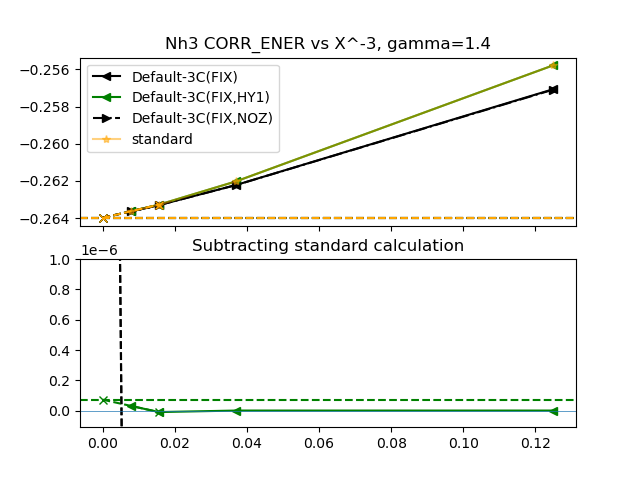

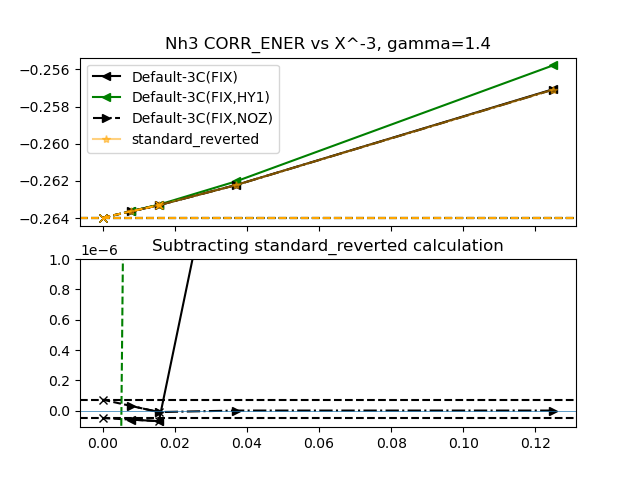

In [9]:
#set(full_df.ansatzes.values)
ansatzes_to_show = [ 
 #'3A(FIX)',
 #'3B(FIX)',
 #'3B(FIX,HX1)',
 #'3B(FIX,HY1)',
 #'3B(FIX,HY2)',
 #'3B(FIX,NOZ)',
 '3C(FIX)',
 '3C(FIX,HY1)',
 #'3C(FIX,HY2)',
 '3C(FIX,NOZ)'
]
gamma = 1.4
system = "nh3"
method = 'standard'

fig, axes = compare_standard_vs_default(
    ansatzes_to_show, gamma, system, method
)
axes[1].set_ylim(-1.1e-7,1e-6)
fig, axes = compare_standard_vs_default(
    ansatzes_to_show, gamma, system, 'standard_reverted'
)
axes[1].set_ylim(-1.1e-7,1e-6)

### Todos
Check basis orbital assignment and fall back options:
```
/home/linux3_i1/amin/molpro_ak-ustutt/Molpro_clean/lib
(theochem) amin@linux3:lib> grep 'def2-QZVPP' *.libmol | grep 'Cu'
```
New input file:
```
basis={
spdfgh,Cu,aug-cc-pVQZ;c;

set,dfmp
s,Cu,"  4.92513000E+02  2.21474000E+02  1.05664000E+02  4.95662000E+01  2.16985000E+01                   
      1.01104000E+01  5.56128000E+00  3.09357000E+00  1.29558000E+00  7.87421000E-01                   
       3.45128000E-01  1.23822000E-01  8.37850000E-02  5.66840000E-02" #comma separate
       
p,Br,31.5779,17.7012,10.3673,5.56829,3.34725,1.86205,1.12814,0.520803,0.290648,0.155863
d,Br,35.4419,14.4095,7.13728,4.02429,2.19901,1.18121,0.537101,0.320289,0.151982
f,Br,16.6283,7.92639,3.69263,1.89967,1.02171,0.418748
g,Br,58.3022,21.9356,7.85160,5.60937,2.04334,1.37529
h,Br,7.51453,3.15089
i,
k, #can try without first.
}

explicit,ri_basis=ri,df_basis=dfmp,df_basis_exch=def2-qzvpp/jkfit
```
could do hf instead of df

### Cu

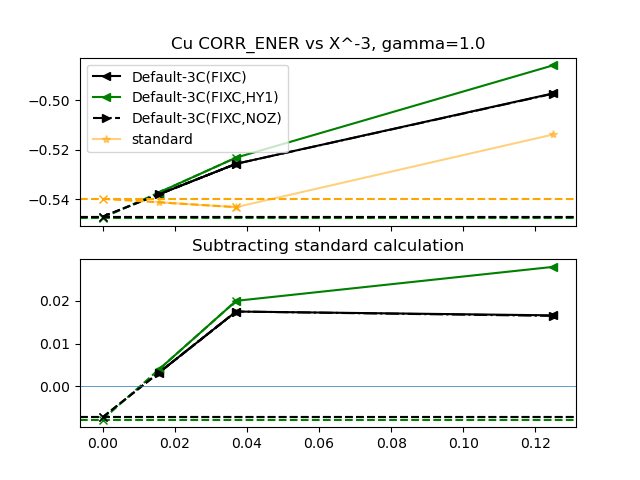

In [8]:
#set(full_df.ansatzes.values)
ansatzes_to_show = [ 
 #'3A(FIX)',
 #'3B(FIX)',
 #'3B(FIX,HX1)',
 #'3B(FIX,HY1)',
 #'3B(FIX,HY2)',
 #'3B(FIX,NOZ)',
 #'3C(FIX)',
 #'3C(FIX,HY1)',
 #'3C(FIX,HY2)',
 #'3C(FIX,NOZ)',
 '3C(FIXC)',
 '3C(FIXC,HY1)',
 #'3C(FIX,HY2)',
 '3C(FIXC,NOZ)'
]
gamma = 1.0
system = "cu"
method = 'standard'

fig, axes = compare_standard_vs_default(
    ansatzes_to_show, gamma, system, method
)
#axes[1].set_ylim(-1.1e-4,1e-3)

#### Standard

In [ ]:
system = "cu"
method = 'standard'
full_df = get_data(f'./{system}/{method}/data.csv')
assign_basis_size(full_df)

## Plot `CORR_ENER` vs `basis_sizes` for select `GEM_BETA` (NH3)

# enertype = 'CORR_ENER'
# fig, ax = plot_all_cbs(
#     full_df, enertype, 'GEM_BETA', [ 2.4],
#     ax=ax
# )
# ax.set_title(f"{system.title()} {enertype} vs X^{-3}")


In [ ]:
system = "cu"
method = 'standard_reverted'
full_df = get_data(f'./{system}/{method}/data.csv')
assign_basis_size(full_df)

## Plot `CORR_ENER` vs `basis_sizes` for select `GEM_BETA` (NH3)
exp = 3
enertype = 'CORR_ENER'
df = full_df[full_df.GEM_BETA == 2.4]
#fig,ax = pp.subplots()
# plot_cbs_extrapolation(
#     df.basis_sizes.values, df.CORR_ENER.values,
#     exp=exp,
#     ax=ax,
#     marker='^',
#     linewidth=4,
#     label=f'standard-reverted'
# )
# ax.set_title(f"{system.title()} {enertype} vs X^{-exp}")


In [ ]:
system = "cu"
method = 'standard'
full_df = get_data(f'./{system}/{method}/data.csv')
assign_basis_size(full_df)


std_df = full_df

# enertype = 'CORR_ENER'
# #fig,ax = pp.subplots()
# fig, ax = plot_all_cbs(
#     full_df, enertype, 'GEM_BETA', [ 1.4],
#     #marker = 'P',
#     ax=axes[0]
# )
# #ax.set_title(f"{system.title()} {enertype} vs X^{-3}")

#### Default

In [ ]:
system = "cu"
method = 'default'
full_df = get_data(f'./{system}/{method}/data.csv')
assign_basis_size(full_df)

print(full_df.columns)
#set(full_df.ansatzes.values)
ansatzes_to_show = [ 
 #'3*A(FIX)',
 #'3*B(FIX)',
 #'3*B(FIX,GBC)',
 #'3*B(FIX,GBC,NOZ)',
 #'3*B(FIX,HX1)',
 #'3*B(FIX,HX1,NOZ)',
 #'3*B(FIX,HY1)',
 #'3*B(FIX,HY1,NOZ)',
 #'3*B(FIX,HY2)',
 #'3*B(FIX,HY2,NOZ)',
 #'3*B(FIX,NOZ)',
 #'3*C(FIX)',
 #'3*C(FIX,HY1)',
 #'3*C(FIX,HY1,NOZ)',
 #'3*C(FIX,HY2)',
 #'3*C(FIX,HY2,NOZ)',
 #'3*C(FIX,NOZ)',
 #'3A(FIX)',
 #'3B(FIX)',
 #'3B(FIX,GBC)',
 #'3B(FIX,GBC,NOZ)',
 #'3B(FIX,HX1)',
 #'3B(FIX,HX1,NOZ)',
 #'3B(FIX,HY1)',
 #'3B(FIX,HY1,NOZ)',
 #'3B(FIX,HY2)',
 #'3B(FIX,HY2,NOZ)',
 #'3B(FIX,NOZ)',
 '3C(FIX)',
 '3C(FIX,HY1)',
 #'3C(FIX,HY1,NOZ)',
 '3C(FIX,HY2)',
 #'3C(FIX,HY2,NOZ)',
 '3C(FIX,NOZ)'
]
gamma = 1.4
ref_df = std_df[std_df.GEM_BETA == gamma]

exp=3
fig, axes = pp.subplots(2,1, sharex=True)

for ansatz in ansatzes_to_show:
    df = full_df[full_df.ansatzes == ansatz]
    df = df[df.GEM_BETA == gamma]
    #print(set(df.ansatzes.values))
    enertype = 'CORR_ENER'
    styles = ansatz_styles(ansatz)
    plot_cbs_extrapolation(
        df.basis_sizes.values, df.CORR_ENER.values,
        exp=exp,
        ax=axes[0],
        **styles,
        #marker='o',
        label=f'Default-{ansatz}'
    )
    plot_cbs_extrapolation(
        df.basis_sizes.values, df.CORR_ENER.values - ref_df.CORR_ENER.values,
        exp=exp,
        ax=axes[1],
        **styles,
        #marker='o',
        #label=f'Default-{ansatz}'
    )

#axes[1].set_ylabel('(Log-scale)')
#ax.set_title(f"{system.title()} {enertype} vs X^{-3}")
axes[1].axhline(0, linewidth=0.5)
axes[0].legend()
axes[0].set_title(f"{system.title()} {enertype} vs X^{-exp}, gamma={gamma}")
axes[1].set_title("Subtracting standard (our own) calculation")
#axes[1].set_ylim(-2e-8,1e-7)

In [ ]:
gamma = 2.4
ax.set_title(f"{system.title()} {enertype} vs X^{-3}, {method}, $\gamma$={gamma}")


#### MP2 and DF-MP2 (Rough)
In order to investigate the impact of basis set and density fitting, we ran with only MP2 - because the python scripts don't handle just MP2 yet, I have copy pasted the values here after doing:

```bash
cd systems/cu/mp2/
grep ' MP2 correlation energy' aug-cc-*/*.out
```
output:
```
aug-cc-PV5Z/mp2.156229-20251021.out:  MP2 correlation energy               -0.527197173134
aug-cc-pVDZ/mp2.156226-20251021.out:  MP2 correlation energy               -0.422075633898
aug-cc-pVQZ/mp2.156228-20251021.out:  MP2 correlation energy               -0.513583673903
aug-cc-pVTZ/mp2.156227-20251021.out:  MP2 correlation energy               -0.484477958323
```

In [ ]:
def output_to_df(output):
    data_dict = dict(bases=[], CORR_ENER=[])
    for n, line in enumerate(output.split('\n')):
        if not line: continue
        basis, corr_ener = line.split('MP2 correlation energy')
        basis = basis.split('/')[0]
        corr_ener = float(corr_ener)
        data_dict['bases'].append(basis)
        data_dict['corr_ener'.upper()].append(corr_ener)
    df = pd.DataFrame(data_dict)
    assign_basis_size(df)
    return df

##### MP2

In [ ]:
output = """
aug-cc-pV5Z/mp2.156230-20251021.out:  MP2 correlation energy               -0.527197173134
aug-cc-pVDZ/mp2.156226-20251021.out:  MP2 correlation energy               -0.422075633898
aug-cc-pVQZ/mp2.156228-20251021.out:  MP2 correlation energy               -0.513583673903
aug-cc-pVTZ/mp2.156227-20251021.out:  MP2 correlation energy               -0.484477958323
"""



df = output_to_df(output).sort_values('basis_sizes')

exp=3
plot_cbs_extrapolation(
    df.basis_sizes.values, df.CORR_ENER.values,
    exp=exp,
    ax=ax,
    marker='o',
    label=f'MP2-exp={exp}'
)
ax.legend()

##### DF-MP2

In [ ]:
output = """
aug-cc-pVDZ/df_mp2.156232-20251021.out:  MP2 correlation energy               -0.422664413406
aug-cc-pVQZ/df_mp2.156234-20251021.out:  MP2 correlation energy               -0.514437957817
aug-cc-pVTZ/df_mp2.156233-20251021.out:  MP2 correlation energy               -0.484454314361
"""
df = output_to_df(output).sort_values('basis_sizes')

exp=3
plot_cbs_extrapolation(
    df.basis_sizes.values, df.CORR_ENER.values,
    exp=exp,
    ax=ax,
    marker='o',
    label=f'DF-MP2-exp={exp}'
)
ax.legend()

## Zn

In [ ]:
#set(full_df.ansatzes.values)
ansatzes_to_show = [ 
 #'3A(FIX)',
 #'3B(FIX)',
 #'3B(FIX,HX1)',
 #'3B(FIX,HY1)',
 #'3B(FIX,HY2)',
 #'3B(FIX,NOZ)',
 '3C(FIX)',
 '3C(FIX,HY1)',
 #'3C(FIX,HY2)',
 '3C(FIX,NOZ)'
]
gamma = 1.0
system = "zn"
method = 'standard'

fig, axes = compare_standard_vs_default(
    ansatzes_to_show, gamma, system, method
)
#axes[1].set_ylim(-1.1e-5,1e-6)

## Zn2+

In [ ]:
#set(full_df.ansatzes.values)
ansatzes_to_show = [ 
 #'3A(FIX)',
 #'3B(FIX)',
 #'3B(FIX,HX1)',
 #'3B(FIX,HY1)',
 #'3B(FIX,HY2)',
 #'3B(FIX,NOZ)',
 '3C(FIX)',
 '3C(FIX,HY1)',
 #'3C(FIX,HY2)',
 '3C(FIX,NOZ)'
]
gamma = 1.0
system = "zn2+"
method = 'standard'

fig, axes = compare_standard_vs_default(
    ansatzes_to_show, gamma, system, method
)
#axes[1].set_ylim(-1.1e-5,1e-6)

## Cu-NH3

### Standard

#### Distances = {2.0, 9999.0}

In [ ]:
system = "cu_nh3"
method = 'standard'
full_df = get_data(f'./{system}/{method}/data.csv')
assign_basis_size(full_df)


enertype = 'CORR_ENER'
distances=(2.0, 9999.0)

fig, axes = pp.subplots(2,1, sharex=True, sharey=True)

for n, distance in enumerate(distances):
    ax = axes[n]
    plot_all_cbs(
        full_df[full_df['distances'] == distance], enertype,
        'GEM_BETA', [1, 1.4, 1.9, 2.4],
        ax = ax
    )

    ax.set_title(f"{system.title()} {enertype} vs X^{-3}, {method} distance={distance:3.1f}")

### XG

#### Distances = {2.0, 9999.0}

In [ ]:
system = "cu_nh3"
method = 'xg'
full_df = get_data(f'./{system}/{method}/data.csv')
assign_basis_size(full_df)
full_df.columns

enertype = 'correlation energy'
distances=(2.0, 9999.0)

fig,axes = pp.subplots(2,1, sharex=True, sharey=True)

for n, distance in enumerate(distances):
    ax = axes[n]
    plot_all_cbs(
        full_df[full_df['distances'] == distance], 
        enertype,
        'gamma_set', sorted(list(set(full_df['gamma_set'].values))),
        ax = ax
    )
    
    ax.set_title(f"{system.title()} {enertype} vs X^{-3}, {method} distance={distance}")

In [ ]:
full_df[full_df.distances == 9999.0]